In [1]:
# Import some qiskit packages required for setting up our quantum circuits.
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import unitary_overlap
 
# Import StatevectorSampler as our sampler.
from qiskit.primitives import StatevectorSampler

--2026-01-28 20:32:40--  https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ... 
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49405 (48K) [text/plain]
Saving to: ‘dataset_graph7.csv’

dataset_graph7.csv  100%[===================>]  48,25K  --.-KB/s    in 0,01s   

2026-01-28 20:32:40 (4,61 MB/s) - ‘dataset_graph7.csv’ saved [49405/49405]



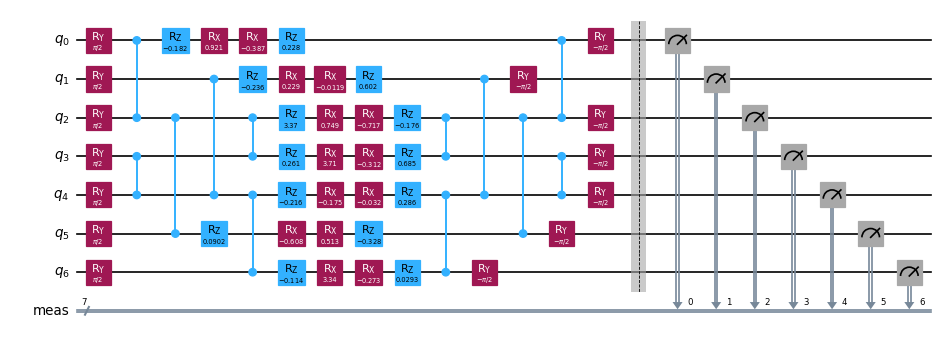

In [2]:
# Step 1: Map classical inputs to a quantum problem:
 
# Start by getting some appropriate data. The data imported below consist of 128 rows or data points.
# Each row has 14 columns that correspond to data features, and a 15th column with a label (+/-1).
!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
 
# Import some required packages, and write a function to pull some training data out of the csv file you got above.
import pandas as pd
import numpy as np
 
 
def get_training_data():
    """Read the training data."""
    df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
    training_data = df.values[:20, :]
    ind = np.argsort(training_data[:, -1])
    X_train = training_data[ind][:, :-1]
 
    return X_train
 
 
# Prepare training data
X_train = get_training_data()
 
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
 
# Prepare feature map for computing overlap between two data points.
# This could be pre-built feature maps like ZZFeatureMap, or a custom quantum circuit, as shown here.
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)
 
# Pick two data points, here 14 and 19, and assign the features to the circuits as parameters.
x1 = 14
x2 = 19
unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
# Create the overlap circuit
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
overlap_circ.draw("mpl", scale=0.6, style="iqp")

In [6]:
# Step 2: Optimize problem for quantum execution
 
# Use Qiskit Runtime service to get the least busy backend for running on real quantum computers.

# from qiskit_ibm_runtime import QiskitRuntimeService
 
# service = QiskitRuntimeService(channel="ibm_quantum_platform")
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=overlap_circ.num_qubits
# )
 
# # Transpile the circuits optimally for the chosen backend using a pass manager.
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
# overlap_ibm = pm.run(overlap_circ)

management.get:WARNING:2026-01-28 20:34:41,189: Loading default saved account


InvalidAccountError: 'Unable to retrieve instances. Please check that you are using a valid API token.'

In [7]:
# Step 3: Execute using Qiskit Runtime Primitives
 
# Specify the number of shots to use.
num_shots = 10_000
 
## Evaluate the problem using statevector-based primitives from Qiskit
sampler = StatevectorSampler()
counts = (
    sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
)
 
# Step 4: Analyze and post-processing
 
# Find the probability of 0.
counts.get(0, 0.0) / num_shots

0.8265